<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install tensorflow-gan tensorflow-addons -q

In [18]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tqdm import tqdm 
import tensorflow_addons as tfa
# from tensorflow_addons.layers import SpectralNormalization //not working

from google.colab import drive, auth

print(tf.__version__)

2.8.2


In [19]:
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.44.154.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.44.154.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [21]:
#@title CONSTS

IMAGE_SIZE = 64
BUFFER_SIZE = 13000
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 120
CHECKPOINT_DIR = '/content/drive/MyDrive/BIGGAN_birds_64/checkpoints'
SAMPLES_DIR = '/content/drive/MyDrive/BIGGAN_birds_64/samples'
CHECKPOINT_INTERVAL = 50
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'


In [22]:
weight_initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=SEED
)
weight_regularizer = None
weight_regularizer_fully = None

In [23]:
def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [24]:
class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_weight(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [25]:
#@title ConditionalBatchNormalization

class ConditionalBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ConditionalBatchNormalization, self).__init__(**kwargs)
    
  def build(self, input_shape):
    batch, height, width, channels = input_shape
   
    self.linear_gamma = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_gamma'))
    self.linear_beta = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_beta'))
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, x, c, training=False):
    x = self.batchnorm(x, training=training)
    gamma = self.linear_gamma(c, training=training)  
    beta = self.linear_beta(c, training=training)

    return x * gamma[:, None, None] + beta[:, None, None]  

In [26]:
#@title SelfAttention

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        in_channels = int(input_shape[-1])

        self.conv_theta =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_phi =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_g =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//2, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_attn =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.sigma = self.add_weight('sigma', shape=[], initializer=tf.zeros_initializer())

    def call(self, x, training=None):
        batch_size, h, w, in_channels = map(int, x.shape.as_list())
        location_num = h*w
        downsampled_num = location_num//4

        theta = self.conv_theta(x, training=training)
        theta = tf.reshape(theta, [batch_size, location_num, in_channels//8])

        phi = self.conv_phi(x, training=training)
        phi = tf.nn.max_pool(phi, ksize=[2, 2], strides=2, padding='VALID')
        phi = tf.reshape(phi, [batch_size, downsampled_num, in_channels//8])

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x, training=training)
        g = tf.nn.max_pool(g, ksize=[2, 2], strides=2, padding='VALID')
        g = tf.reshape(g, [batch_size, downsampled_num, in_channels//2])

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [batch_size, h, w, in_channels//2])
        attn_g = self.conv_attn(attn_g, training=training)

        return x + self.sigma * attn_g

In [27]:
#@title DBlock

class DBlock(Model):
  def __init__(self, channels, downsample=True, preactivation=True):
    super(DBlock, self).__init__()
    self.out_channels = channels
    self.hidden_channels = self.out_channels 
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.hidden_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
    
    self.downsample = downsample
    self.preactivation = preactivation
  
  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = True if (self.in_channels != self.out_channels) or self.downsample else False

    if self.learnable_sc:
      self.conv_sc = tfa.layers.SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))

  def shortcut(self, x, training=False):
    if self.preactivation:
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
      if self.downsample:
        x = self.av_pool_1(x)
    else:
      if self.downsample:
        x = self.av_pool_1(x)
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
    return x

  def call(self, x, training=False):
    if self.preactivation:
      h = self.activation1(x)
    else:
      h = x    

    h = self.conv33_1(h, training=training)
    h = self.conv33_2(self.activation2(h), training=training)

    if self.downsample:
      h = self.av_pool_2(h)     
        
    return h + self.shortcut(x, training=training)           


In [28]:
#@title GBlock

class GBlock(Model):
  def __init__(self, channels):
    super(GBlock, self).__init__()
    self.out_channels = channels
    self.bn1 = ConditionalBatchNormalization()
    self.bn2 = ConditionalBatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.upsample = True

  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = self.in_channels != self.out_channels

    if self.learnable_sc:
      self.conv_sc = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
      
  def call(self, x, label, training=False):
    h = self.activation1(self.bn1(x, label, training=training))
    if self.upsample:
      h = self.up_sample_1(h)
      x = self.up_sample_2(x)

    h = self.conv33_1(h, training=training)
    h = self.activation2(self.bn2(h, label, training=training))
    h = self.conv33_2(h, training=training)

    if self.learnable_sc:       
      x = self.conv_sc(x, training=training)

    return h + x

In [29]:
class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully))
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels)
    self.res_block_2 = GBlock(16 * channels)
    self.res_block_3 = GBlock(8 * channels)
    self.attention = SelfAttention()
    self.res_block_4 = GBlock(4 * channels)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.concat = tf.keras.layers.Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=5, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

(1, 144) <dtype: 'float32'>
(1, 144) <dtype: 'float32'>
(1, 64, 64, 3)


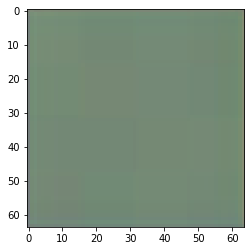

In [30]:
with strategy.scope():
  generator = Generator(64, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [31]:
class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True)
    self.attention = SelfAttention()
    self.res_block_5 = DBlock(16 * channels, downsample=False, preactivation=True)
    self.activation = tf.keras.layers.ReLU()
    self.embedding = Embedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)

    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [32]:
with strategy.scope():
  discriminator = Discriminator(64, num_classes=NUM_CLASSES)
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[0.00157929]], shape=(1, 1), dtype=float32)


In [33]:
per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=per_replica_batch_size,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_hinge_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor:
  L_D = -tf.reduce_mean(tf.minimum(0., -1.0 + logits_real)) - tf.reduce_mean(tf.minimum(0., -1.0 - logits_fake))

  return L_D    

def generator_hinge_loss(logits_fake: tf.Tensor) -> tf.Tensor:
    L_G = -tf.reduce_mean(logits_fake)
    return L_G  

In [35]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.0, beta_2=0.999,epsilon=1e-6,)
  discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.0, beta_2=0.999, epsilon=1e-6)

In [36]:
fixed_noise = tf.random.truncated_normal((100, LATENT_DIM), stddev=1)

def sample_images(epoch):
  rows = 10
  cols = 10

  noise = fixed_noise

  labels = np.arange(0, 100)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(wspace=0.01, hspace=0)

  fig.set_figheight(100)
  fig.set_figwidth(100)
  fig.set_tight_layout(True)
 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * 10 + i])
  
      axs[i,j].axis('off')
  plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close(fig)

In [37]:
with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_hinge_loss(real_predictions, gen_predictions)
      gen_loss = generator_hinge_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  generator=generator,
  discriminator=discriminator)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
status = checkpoint.restore(latest_checkpoint, options=local_device_option)

if latest_checkpoint:
  first_epoch = int(latest_checkpoint.split(sep='ckpt-')[-1]) * CHECKPOINT_INTERVAL
else:
  first_epoch = 0

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

def save_checkpoint():
  checkpoint_dir = CHECKPOINT_DIR
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(first_epoch, EPOCHS):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch + 1, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if (epoch + 1) % 5 == 0:
    sample_images(epoch)
    
  if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()

  print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch: 1/200


  0%|          | 0/406 [00:00<?, ?it/s]

(4, 144) <dtype: 'float32'>


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(4,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(4, 120), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_1:0", shape=(8,), dtype=int64), values=Tensor("concat:0", shape=(8, 1024), dtype=float32), dense_shape=Tensor("PartitionedCall_2:59", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


(4, 144) <dtype: 'float32'>


Current step 406: 100%|██████████| 406/406 [05:09<00:00,  1.31it/s, disc_loss=0.449, gen_loss=0.681]


Time for epoch 1 is 309.121218919754 sec
Epoch: 2/200


Current step 812: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=1.79, gen_loss=-.235]


Time for epoch 2 is 34.40639615058899 sec
Epoch: 3/200


Current step 1218: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.0278, gen_loss=1.6]


Time for epoch 3 is 34.505966901779175 sec
Epoch: 4/200


Current step 1624: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.0861, gen_loss=2.04]


Time for epoch 4 is 34.553088426589966 sec
Epoch: 5/200


Current step 2030: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.164, gen_loss=1.4]


(100, 144) <dtype: 'float32'>
Time for epoch 5 is 53.30950593948364 sec
Epoch: 6/200


Current step 2436: 100%|██████████| 406/406 [00:34<00:00, 11.71it/s, disc_loss=1.47, gen_loss=2.57]


Time for epoch 6 is 34.66800904273987 sec
Epoch: 7/200


Current step 2842: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.58, gen_loss=1.69]


Time for epoch 7 is 34.612056016922 sec
Epoch: 8/200


Current step 3248: 100%|██████████| 406/406 [00:34<00:00, 11.69it/s, disc_loss=0.115, gen_loss=1.59]


Time for epoch 8 is 34.72279453277588 sec
Epoch: 9/200


Current step 3654: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.812, gen_loss=1.6]


Time for epoch 9 is 34.44492530822754 sec
Epoch: 10/200


Current step 4060: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.5, gen_loss=0.918]


Time for epoch 10 is 50.075071573257446 sec
Epoch: 11/200


Current step 4466: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.381, gen_loss=1.03]


Time for epoch 11 is 34.59032368659973 sec
Epoch: 12/200


Current step 4872: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.176, gen_loss=1.65]


Time for epoch 12 is 34.59195852279663 sec
Epoch: 13/200


Current step 5278: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.0946, gen_loss=1.46]


Time for epoch 13 is 34.49999761581421 sec
Epoch: 14/200


Current step 5684: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.527, gen_loss=1.74]


Time for epoch 14 is 34.57532501220703 sec
Epoch: 15/200


Current step 6090: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.366, gen_loss=1.65]


Time for epoch 15 is 49.85042762756348 sec
Epoch: 16/200


Current step 6496: 100%|██████████| 406/406 [00:34<00:00, 11.81it/s, disc_loss=0.26, gen_loss=1.9]


Time for epoch 16 is 34.396302461624146 sec
Epoch: 17/200


Current step 6902: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.468, gen_loss=1.69]


Time for epoch 17 is 34.46466779708862 sec
Epoch: 18/200


Current step 7308: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.194, gen_loss=2.05]


Time for epoch 18 is 34.53201341629028 sec
Epoch: 19/200


Current step 7714: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.361, gen_loss=1.35]


Time for epoch 19 is 34.54343557357788 sec
Epoch: 20/200


Current step 8120: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.422, gen_loss=1.88]


Time for epoch 20 is 49.906726360321045 sec
Epoch: 21/200


Current step 8526: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.116, gen_loss=1.65]


Time for epoch 21 is 34.55859160423279 sec
Epoch: 22/200


Current step 8932: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.269, gen_loss=1.42]


Time for epoch 22 is 34.59048342704773 sec
Epoch: 23/200


Current step 9338: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.46, gen_loss=1.38]


Time for epoch 23 is 34.52670097351074 sec
Epoch: 24/200


Current step 9744: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.339, gen_loss=2.1]


Time for epoch 24 is 34.561224699020386 sec
Epoch: 25/200


Current step 10150: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.321, gen_loss=1.29]


Time for epoch 25 is 53.16251349449158 sec
Epoch: 26/200


Current step 10556: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.435, gen_loss=2.34]


Time for epoch 26 is 34.50520849227905 sec
Epoch: 27/200


Current step 10962: 100%|██████████| 406/406 [00:34<00:00, 11.69it/s, disc_loss=0.0569, gen_loss=2.45]


Time for epoch 27 is 34.75027847290039 sec
Epoch: 28/200


Current step 11368: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.306, gen_loss=2.13]


Time for epoch 28 is 34.55192184448242 sec
Epoch: 29/200


Current step 11774: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.331, gen_loss=2.37]


Time for epoch 29 is 34.473530769348145 sec
Epoch: 30/200


Current step 12180: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.175, gen_loss=1.9]


Time for epoch 30 is 49.875911235809326 sec
Epoch: 31/200


Current step 12586: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.443, gen_loss=1.11]


Time for epoch 31 is 34.471760988235474 sec
Epoch: 32/200


Current step 12992: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.501, gen_loss=1.32]


Time for epoch 32 is 34.43138074874878 sec
Epoch: 33/200


Current step 13398: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.269, gen_loss=2.66]


Time for epoch 33 is 34.55643010139465 sec
Epoch: 34/200


Current step 13804: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.662, gen_loss=2.9]


Time for epoch 34 is 34.56840658187866 sec
Epoch: 35/200


Current step 14210: 100%|██████████| 406/406 [00:34<00:00, 11.71it/s, disc_loss=0.378, gen_loss=1.55]


Time for epoch 35 is 50.02056050300598 sec
Epoch: 36/200


Current step 14616: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.285, gen_loss=2.37]


Time for epoch 36 is 34.4671905040741 sec
Epoch: 37/200


Current step 15022: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.808, gen_loss=0.466]


Time for epoch 37 is 34.532219886779785 sec
Epoch: 38/200


Current step 15428: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.221, gen_loss=2.93]


Time for epoch 38 is 34.49167060852051 sec
Epoch: 39/200


Current step 15834: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.13, gen_loss=2.07]


Time for epoch 39 is 34.51211762428284 sec
Epoch: 40/200


Current step 16240: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.0352, gen_loss=2.5]


Time for epoch 40 is 49.65102696418762 sec
Epoch: 41/200


Current step 16646: 100%|██████████| 406/406 [00:34<00:00, 11.81it/s, disc_loss=0.337, gen_loss=1.7]


Time for epoch 41 is 34.39122486114502 sec
Epoch: 42/200


Current step 17052: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.441, gen_loss=2.76]


Time for epoch 42 is 34.39780378341675 sec
Epoch: 43/200


Current step 17458: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.565, gen_loss=2.77]


Time for epoch 43 is 34.47157621383667 sec
Epoch: 44/200


Current step 17864: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.248, gen_loss=1.68]


Time for epoch 44 is 34.45146369934082 sec
Epoch: 45/200


Current step 18270: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.388, gen_loss=1.32]


Time for epoch 45 is 50.1147096157074 sec
Epoch: 46/200


Current step 18676: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.076, gen_loss=2.44]


Time for epoch 46 is 34.4668984413147 sec
Epoch: 47/200


Current step 19082: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.338, gen_loss=3.15]


Time for epoch 47 is 34.53898644447327 sec
Epoch: 48/200


Current step 19488: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.246, gen_loss=2.56]


Time for epoch 48 is 34.58586597442627 sec
Epoch: 49/200


Current step 19894: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.427, gen_loss=3.25]


Time for epoch 49 is 34.58048129081726 sec
Epoch: 50/200


Current step 20300: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.093, gen_loss=2.86]


Time for epoch 50 is 58.83386278152466 sec
Epoch: 51/200


Current step 20706: 100%|██████████| 406/406 [00:35<00:00, 11.33it/s, disc_loss=0.189, gen_loss=1.61]


Time for epoch 51 is 35.82750678062439 sec
Epoch: 52/200


Current step 21112: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.42, gen_loss=1.86]


Time for epoch 52 is 34.43753695487976 sec
Epoch: 53/200


Current step 21518: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.101, gen_loss=2.71]


Time for epoch 53 is 34.4011914730072 sec
Epoch: 54/200


Current step 21924: 100%|██████████| 406/406 [00:34<00:00, 11.82it/s, disc_loss=0.263, gen_loss=2.15]


Time for epoch 54 is 34.34171438217163 sec
Epoch: 55/200


Current step 22330: 100%|██████████| 406/406 [00:34<00:00, 11.81it/s, disc_loss=0.294, gen_loss=2.87]


Time for epoch 55 is 48.94876408576965 sec
Epoch: 56/200


Current step 22736: 100%|██████████| 406/406 [00:34<00:00, 11.82it/s, disc_loss=0.336, gen_loss=2.7]


Time for epoch 56 is 34.35047674179077 sec
Epoch: 57/200


Current step 23142: 100%|██████████| 406/406 [00:34<00:00, 11.81it/s, disc_loss=0.383, gen_loss=2.46]


Time for epoch 57 is 34.382466554641724 sec
Epoch: 58/200


Current step 23548: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.318, gen_loss=2.75]


Time for epoch 58 is 34.404181241989136 sec
Epoch: 59/200


Current step 23954: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.451, gen_loss=1.23]


Time for epoch 59 is 34.44511914253235 sec
Epoch: 60/200


Current step 24360: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.353, gen_loss=2.65]


Time for epoch 60 is 49.83947157859802 sec
Epoch: 61/200


Current step 24766: 100%|██████████| 406/406 [00:34<00:00, 11.83it/s, disc_loss=0.358, gen_loss=1.85]


Time for epoch 61 is 34.32261896133423 sec
Epoch: 62/200


Current step 25172: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.275, gen_loss=1.56]


Time for epoch 62 is 34.44057083129883 sec
Epoch: 63/200


Current step 25578: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.384, gen_loss=1.79]


Time for epoch 63 is 34.546976804733276 sec
Epoch: 64/200


Current step 25984: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=1.01, gen_loss=4.52]


Time for epoch 64 is 34.445144176483154 sec
Epoch: 65/200


Current step 26390: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.135, gen_loss=2.14]


Time for epoch 65 is 49.353358030319214 sec
Epoch: 66/200


Current step 26796: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.327, gen_loss=2.69]


Time for epoch 66 is 34.51746344566345 sec
Epoch: 67/200


Current step 27202: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.107, gen_loss=2.67]


Time for epoch 67 is 34.43967318534851 sec
Epoch: 68/200


Current step 27608: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.265, gen_loss=2.14]


Time for epoch 68 is 34.492098569869995 sec
Epoch: 69/200


Current step 28014: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.338, gen_loss=2]


Time for epoch 69 is 34.56231951713562 sec
Epoch: 70/200


Current step 28420: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.241, gen_loss=2.55]


Time for epoch 70 is 49.57423639297485 sec
Epoch: 71/200


Current step 28826: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.337, gen_loss=1.88]


Time for epoch 71 is 34.57858991622925 sec
Epoch: 72/200


Current step 29232: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.222, gen_loss=2.71]


Time for epoch 72 is 34.41341471672058 sec
Epoch: 73/200


Current step 29638: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.142, gen_loss=2.21]


Time for epoch 73 is 34.47278666496277 sec
Epoch: 74/200


Current step 30044: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.268, gen_loss=2.77]


Time for epoch 74 is 34.48783874511719 sec
Epoch: 75/200


Current step 30450: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.217, gen_loss=2.81]


Time for epoch 75 is 49.82944345474243 sec
Epoch: 76/200


Current step 30856: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.11, gen_loss=2.77]


Time for epoch 76 is 34.50464200973511 sec
Epoch: 77/200


Current step 31262: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.331, gen_loss=1.8]


Time for epoch 77 is 34.59647297859192 sec
Epoch: 78/200


Current step 31668: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.201, gen_loss=1.97]


Time for epoch 78 is 34.58043551445007 sec
Epoch: 79/200


Current step 32074: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.293, gen_loss=2.29]


Time for epoch 79 is 34.42579960823059 sec
Epoch: 80/200


Current step 32480: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.502, gen_loss=1.46]


Time for epoch 80 is 50.01317763328552 sec
Epoch: 81/200


Current step 32886: 100%|██████████| 406/406 [00:34<00:00, 11.81it/s, disc_loss=0.332, gen_loss=2.15]


Time for epoch 81 is 34.37487053871155 sec
Epoch: 82/200


Current step 33292: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.149, gen_loss=1.87]


Time for epoch 82 is 34.594778060913086 sec
Epoch: 83/200


Current step 33698: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.335, gen_loss=1.65]


Time for epoch 83 is 34.6568877696991 sec
Epoch: 84/200


Current step 34104: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.549, gen_loss=3.05]


Time for epoch 84 is 34.509355545043945 sec
Epoch: 85/200


Current step 34510: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.303, gen_loss=3.21]


Time for epoch 85 is 52.84213852882385 sec
Epoch: 86/200


Current step 34916: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.412, gen_loss=1.67]


Time for epoch 86 is 34.53010153770447 sec
Epoch: 87/200


Current step 35322: 100%|██████████| 406/406 [00:34<00:00, 11.82it/s, disc_loss=0.283, gen_loss=1.67]


Time for epoch 87 is 34.36250686645508 sec
Epoch: 88/200


Current step 35728: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.201, gen_loss=2.73]


Time for epoch 88 is 34.554115772247314 sec
Epoch: 89/200


Current step 36134: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.249, gen_loss=3.05]


Time for epoch 89 is 34.497870206832886 sec
Epoch: 90/200


Current step 36540: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.166, gen_loss=2.44]


Time for epoch 90 is 50.07280135154724 sec
Epoch: 91/200


Current step 36946: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.101, gen_loss=2.69]


Time for epoch 91 is 34.433759450912476 sec
Epoch: 92/200


Current step 37352: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.415, gen_loss=4.27]


Time for epoch 92 is 34.53683161735535 sec
Epoch: 93/200


Current step 37758: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.176, gen_loss=2.41]


Time for epoch 93 is 34.49694490432739 sec
Epoch: 94/200


Current step 38164: 100%|██████████| 406/406 [00:34<00:00, 11.70it/s, disc_loss=0.0339, gen_loss=2.73]


Time for epoch 94 is 34.70094871520996 sec
Epoch: 95/200


Current step 38570: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.181, gen_loss=3.59]


Time for epoch 95 is 50.11707425117493 sec
Epoch: 96/200


Current step 38976: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.385, gen_loss=1.4]


Time for epoch 96 is 34.40175151824951 sec
Epoch: 97/200


Current step 39382: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.187, gen_loss=3]


Time for epoch 97 is 34.58119559288025 sec
Epoch: 98/200


Current step 39788: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.316, gen_loss=1.6]


Time for epoch 98 is 34.46426963806152 sec
Epoch: 99/200


Current step 40194: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.184, gen_loss=2.24]


Time for epoch 99 is 34.48101353645325 sec
Epoch: 100/200


Current step 40600: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.205, gen_loss=2.19]


Time for epoch 100 is 57.42152953147888 sec
Epoch: 101/200


Current step 41006: 100%|██████████| 406/406 [00:36<00:00, 11.22it/s, disc_loss=0.117, gen_loss=2.03]


Time for epoch 101 is 36.179309129714966 sec
Epoch: 102/200


Current step 41412: 100%|██████████| 406/406 [00:34<00:00, 11.70it/s, disc_loss=0.0729, gen_loss=3.21]


Time for epoch 102 is 34.71779417991638 sec
Epoch: 103/200


Current step 41818: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.132, gen_loss=2.39]


Time for epoch 103 is 34.6575710773468 sec
Epoch: 104/200


Current step 42224: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.532, gen_loss=1.39]


Time for epoch 104 is 34.46467566490173 sec
Epoch: 105/200


Current step 42630: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.0269, gen_loss=3.13]


Time for epoch 105 is 49.80384540557861 sec
Epoch: 106/200


Current step 43036: 100%|██████████| 406/406 [00:34<00:00, 11.71it/s, disc_loss=0.576, gen_loss=3.73]


Time for epoch 106 is 34.66719913482666 sec
Epoch: 107/200


Current step 43442: 100%|██████████| 406/406 [00:34<00:00, 11.70it/s, disc_loss=0.115, gen_loss=2.4]


Time for epoch 107 is 34.69447302818298 sec
Epoch: 108/200


Current step 43848: 100%|██████████| 406/406 [00:34<00:00, 11.68it/s, disc_loss=0.554, gen_loss=3.76]


Time for epoch 108 is 34.7696168422699 sec
Epoch: 109/200


Current step 44254: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.219, gen_loss=2.17]


Time for epoch 109 is 34.556812047958374 sec
Epoch: 110/200


Current step 44660: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.322, gen_loss=3.15]


Time for epoch 110 is 49.84401822090149 sec
Epoch: 111/200


Current step 45066: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.195, gen_loss=3]


Time for epoch 111 is 34.50229835510254 sec
Epoch: 112/200


Current step 45472: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.419, gen_loss=3.63]


Time for epoch 112 is 34.64598083496094 sec
Epoch: 113/200


Current step 45878: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.199, gen_loss=2]


Time for epoch 113 is 34.528794288635254 sec
Epoch: 114/200


Current step 46284: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.466, gen_loss=2.84]


Time for epoch 114 is 34.49004578590393 sec
Epoch: 115/200


Current step 46690: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.197, gen_loss=2.72]


Time for epoch 115 is 49.947922706604004 sec
Epoch: 116/200


Current step 47096: 100%|██████████| 406/406 [00:34<00:00, 11.69it/s, disc_loss=0.266, gen_loss=2.07]


Time for epoch 116 is 34.7400643825531 sec
Epoch: 117/200


Current step 47502: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.197, gen_loss=2.87]


Time for epoch 117 is 34.64690613746643 sec
Epoch: 118/200


Current step 47908: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.199, gen_loss=1.92]


Time for epoch 118 is 34.51972150802612 sec
Epoch: 119/200


Current step 48314: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.225, gen_loss=3.14]


Time for epoch 119 is 34.55028462409973 sec
Epoch: 120/200


Current step 48720: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.116, gen_loss=2.31]


Time for epoch 120 is 49.629753828048706 sec
Epoch: 121/200


Current step 49126: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.255, gen_loss=2.21]


Time for epoch 121 is 34.522218465805054 sec
Epoch: 122/200


Current step 49532: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.323, gen_loss=2.69]


Time for epoch 122 is 34.53257441520691 sec
Epoch: 123/200


Current step 49938: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.176, gen_loss=2.14]


Time for epoch 123 is 34.55872416496277 sec
Epoch: 124/200


Current step 50344: 100%|██████████| 406/406 [00:34<00:00, 11.83it/s, disc_loss=0.048, gen_loss=3.07]


Time for epoch 124 is 34.311190605163574 sec
Epoch: 125/200


Current step 50750: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.233, gen_loss=2.43]


Time for epoch 125 is 52.91820788383484 sec
Epoch: 126/200


Current step 51156: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.225, gen_loss=3.25]


Time for epoch 126 is 34.48774528503418 sec
Epoch: 127/200


Current step 51562: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.489, gen_loss=1.07]


Time for epoch 127 is 34.60978174209595 sec
Epoch: 128/200


Current step 51968: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.147, gen_loss=2.6]


Time for epoch 128 is 34.586419105529785 sec
Epoch: 129/200


Current step 52374: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.0856, gen_loss=1.84]


Time for epoch 129 is 34.63730549812317 sec
Epoch: 130/200


Current step 52780: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.217, gen_loss=2.58]


Time for epoch 130 is 49.958730936050415 sec
Epoch: 131/200


Current step 53186: 100%|██████████| 406/406 [00:34<00:00, 11.70it/s, disc_loss=0.066, gen_loss=2.45]


Time for epoch 131 is 34.711647272109985 sec
Epoch: 132/200


Current step 53592: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.18, gen_loss=2.82]


Time for epoch 132 is 34.62217426300049 sec
Epoch: 133/200


Current step 53998: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.343, gen_loss=2.23]


Time for epoch 133 is 34.55394268035889 sec
Epoch: 134/200


Current step 54404: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.154, gen_loss=2.85]


Time for epoch 134 is 34.593971729278564 sec
Epoch: 135/200


Current step 54810: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.341, gen_loss=1.55]


Time for epoch 135 is 49.72690033912659 sec
Epoch: 136/200


Current step 55216: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.143, gen_loss=2.36]


Time for epoch 136 is 34.47995662689209 sec
Epoch: 137/200


Current step 55622: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.4, gen_loss=3.4]


Time for epoch 137 is 34.53226447105408 sec
Epoch: 138/200


Current step 56028: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.282, gen_loss=2.25]


Time for epoch 138 is 34.47100758552551 sec
Epoch: 139/200


Current step 56434: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.289, gen_loss=1.68]


Time for epoch 139 is 34.57716202735901 sec
Epoch: 140/200


Current step 56840: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.27, gen_loss=2.08]


Time for epoch 140 is 49.68809413909912 sec
Epoch: 141/200


Current step 57246: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.321, gen_loss=1.86]


Time for epoch 141 is 34.468048334121704 sec
Epoch: 142/200


Current step 57652: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.333, gen_loss=2.98]


Time for epoch 142 is 34.48884892463684 sec
Epoch: 143/200


Current step 58058: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.233, gen_loss=2.85]


Time for epoch 143 is 34.619224071502686 sec
Epoch: 144/200


Current step 58464: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.247, gen_loss=3.03]


Time for epoch 144 is 34.608861446380615 sec
Epoch: 145/200


Current step 58870: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.42, gen_loss=1.55]


Time for epoch 145 is 50.23555660247803 sec
Epoch: 146/200


Current step 59276: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.282, gen_loss=1.78]


Time for epoch 146 is 34.45797920227051 sec
Epoch: 147/200


Current step 59682: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.374, gen_loss=2.63]


Time for epoch 147 is 34.4968523979187 sec
Epoch: 148/200


Current step 60088: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.235, gen_loss=2.59]


Time for epoch 148 is 34.528194189071655 sec
Epoch: 149/200


Current step 60494: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.49, gen_loss=3.19]


Time for epoch 149 is 34.48094940185547 sec
Epoch: 150/200


Current step 60900: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.15, gen_loss=2.72]


Time for epoch 150 is 55.50764346122742 sec
Epoch: 151/200


Current step 61306: 100%|██████████| 406/406 [00:37<00:00, 10.91it/s, disc_loss=0.258, gen_loss=2.93]


Time for epoch 151 is 37.209025621414185 sec
Epoch: 152/200


Current step 61712: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.416, gen_loss=1.73]


Time for epoch 152 is 34.48692083358765 sec
Epoch: 153/200


Current step 62118: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.216, gen_loss=2.14]


Time for epoch 153 is 34.535261154174805 sec
Epoch: 154/200


Current step 62524: 100%|██████████| 406/406 [00:34<00:00, 11.81it/s, disc_loss=0.547, gen_loss=1.03]


Time for epoch 154 is 34.39251446723938 sec
Epoch: 155/200


Current step 62930: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.339, gen_loss=3.39]


Time for epoch 155 is 49.05656433105469 sec
Epoch: 156/200


Current step 63336: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.557, gen_loss=1.13]


Time for epoch 156 is 34.44534158706665 sec
Epoch: 157/200


Current step 63742: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.412, gen_loss=2.6]


Time for epoch 157 is 34.410419940948486 sec
Epoch: 158/200


Current step 64148: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.186, gen_loss=2.31]


Time for epoch 158 is 34.456003189086914 sec
Epoch: 159/200


Current step 64554: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.378, gen_loss=1.89]


Time for epoch 159 is 34.569616079330444 sec
Epoch: 160/200


Current step 64960: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.31, gen_loss=1.73]


Time for epoch 160 is 49.4215669631958 sec
Epoch: 161/200


Current step 65366: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.262, gen_loss=2.35]


Time for epoch 161 is 34.440932750701904 sec
Epoch: 162/200


Current step 65772: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.514, gen_loss=3.41]


Time for epoch 162 is 34.65616512298584 sec
Epoch: 163/200


Current step 66178: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.671, gen_loss=1.01]


Time for epoch 163 is 34.63213109970093 sec
Epoch: 164/200


Current step 66584: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.561, gen_loss=1.51]


Time for epoch 164 is 34.55670094490051 sec
Epoch: 165/200


Current step 66990: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.291, gen_loss=2.56]


Time for epoch 165 is 49.38388156890869 sec
Epoch: 166/200


Current step 67396: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.151, gen_loss=2.15]


Time for epoch 166 is 34.48409700393677 sec
Epoch: 167/200


Current step 67802: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.375, gen_loss=3.39]


Time for epoch 167 is 34.45842909812927 sec
Epoch: 168/200


Current step 68208: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.239, gen_loss=2.57]


Time for epoch 168 is 34.428008794784546 sec
Epoch: 169/200


Current step 68614: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.36, gen_loss=2.38]


Time for epoch 169 is 34.453333616256714 sec
Epoch: 170/200


Current step 69020: 100%|██████████| 406/406 [00:34<00:00, 11.77it/s, disc_loss=0.129, gen_loss=2.73]


Time for epoch 170 is 49.137322664260864 sec
Epoch: 171/200


Current step 69426: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.57, gen_loss=1.36]


Time for epoch 171 is 34.4397349357605 sec
Epoch: 172/200


Current step 69832: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.442, gen_loss=2.1]


Time for epoch 172 is 34.57062101364136 sec
Epoch: 173/200


Current step 70238: 100%|██████████| 406/406 [00:34<00:00, 11.82it/s, disc_loss=0.146, gen_loss=2.1]


Time for epoch 173 is 34.348416805267334 sec
Epoch: 174/200


Current step 70644: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.386, gen_loss=2.82]


Time for epoch 174 is 34.43201041221619 sec
Epoch: 175/200


Current step 71050: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.389, gen_loss=2.04]


Time for epoch 175 is 53.615480184555054 sec
Epoch: 176/200


Current step 71456: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.564, gen_loss=2.84]


Time for epoch 176 is 34.43371105194092 sec
Epoch: 177/200


Current step 71862: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.397, gen_loss=1.45]


Time for epoch 177 is 34.564921140670776 sec
Epoch: 178/200


Current step 72268: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.246, gen_loss=2.12]


Time for epoch 178 is 34.62421655654907 sec
Epoch: 179/200


Current step 72674: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.443, gen_loss=2.77]


Time for epoch 179 is 34.5458459854126 sec
Epoch: 180/200


Current step 73080: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.274, gen_loss=1.73]


Time for epoch 180 is 49.335734844207764 sec
Epoch: 181/200


Current step 73486: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.292, gen_loss=2.46]


Time for epoch 181 is 34.613922357559204 sec
Epoch: 182/200


Current step 73892: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.531, gen_loss=0.933]


Time for epoch 182 is 34.61489796638489 sec
Epoch: 183/200


Current step 74298: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.515, gen_loss=2.59]


Time for epoch 183 is 34.438082218170166 sec
Epoch: 184/200


Current step 74704: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.45, gen_loss=2.92]


Time for epoch 184 is 34.5238618850708 sec
Epoch: 185/200


Current step 75110: 100%|██████████| 406/406 [00:34<00:00, 11.73it/s, disc_loss=0.336, gen_loss=2.49]


Time for epoch 185 is 49.373226165771484 sec
Epoch: 186/200


Current step 75516: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.342, gen_loss=1.9]


Time for epoch 186 is 34.558359146118164 sec
Epoch: 187/200


Current step 75922: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.276, gen_loss=2.07]


Time for epoch 187 is 34.47370409965515 sec
Epoch: 188/200


Current step 76328: 100%|██████████| 406/406 [00:34<00:00, 11.78it/s, disc_loss=0.163, gen_loss=2.54]


Time for epoch 188 is 34.48085355758667 sec
Epoch: 189/200


Current step 76734: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.481, gen_loss=2.88]


Time for epoch 189 is 34.560556411743164 sec
Epoch: 190/200


Current step 77140: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.347, gen_loss=1.63]


Time for epoch 190 is 49.47488045692444 sec
Epoch: 191/200


Current step 77546: 100%|██████████| 406/406 [00:34<00:00, 11.74it/s, disc_loss=0.377, gen_loss=3.12]


Time for epoch 191 is 34.59457015991211 sec
Epoch: 192/200


Current step 77952: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.829, gen_loss=0.759]


Time for epoch 192 is 34.45130491256714 sec
Epoch: 193/200


Current step 78358: 100%|██████████| 406/406 [00:34<00:00, 11.72it/s, disc_loss=0.262, gen_loss=1.38]


Time for epoch 193 is 34.64344072341919 sec
Epoch: 194/200


Current step 78764: 100%|██████████| 406/406 [00:34<00:00, 11.76it/s, disc_loss=0.188, gen_loss=2.49]


Time for epoch 194 is 34.53882694244385 sec
Epoch: 195/200


Current step 79170: 100%|██████████| 406/406 [00:34<00:00, 11.75it/s, disc_loss=0.373, gen_loss=1.64]


Time for epoch 195 is 49.338892221450806 sec
Epoch: 196/200


Current step 79576: 100%|██████████| 406/406 [00:34<00:00, 11.84it/s, disc_loss=0.362, gen_loss=1.91]


Time for epoch 196 is 34.30239224433899 sec
Epoch: 197/200


Current step 79982: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.24, gen_loss=2.39]


Time for epoch 197 is 34.42718148231506 sec
Epoch: 198/200


Current step 80388: 100%|██████████| 406/406 [00:34<00:00, 11.79it/s, disc_loss=0.294, gen_loss=2.59]


Time for epoch 198 is 34.43481421470642 sec
Epoch: 199/200


Current step 80794: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.462, gen_loss=2.47]


Time for epoch 199 is 34.41056704521179 sec
Epoch: 200/200


Current step 81200: 100%|██████████| 406/406 [00:34<00:00, 11.80it/s, disc_loss=0.123, gen_loss=2.72]


Time for epoch 200 is 55.35598039627075 sec
